## Data Preprocessing

In [21]:
import numpy as np 
import pandas as pd 

import warnings
warnings.filterwarnings('ignore')

### Import data

In [3]:
player_df = pd.read_csv('epl-players-2010-2023-stats.csv', index_col=0)
player_df.shape

(8112, 269)

### Name corrections

In [4]:
wrong_names = player_df[player_df['full_name'].str.contains('u00', na=False)]['full_name'].unique()
print(wrong_names)

['Abdoulaye Mu00e9u00eftu00e9' 'Cheik Ismau00ebl Tiotu00e9'
 'Didier Yves Drogba Tu00e9bily' 'Emmanuel Ebouu00e9'
 'Gnu00e9gnu00e9ri Yaya Touru00e9' 'Kolo Habib Touru00e9'
 'Lohoru00e9 Steve Ulrich Gohouri' 'Arouna Konu00e9' 'Lacina Traoru00e9'
 'Lamine Konu00e9' 'Jean Michau00ebl Seri']


In [5]:
name_corrections = {
    'Gnu00e9gnu00e9ri Yaya Touru00e9': 'Yaya Touré',
    'Abdoulaye Mu00e9u00eftu00e9': 'Abdoulaye Méïté',
    'Cheik Ismau00ebl Tiotu00e9': 'Cheik Ismaël Tioté',
    'Emmanuel Ebouu00e9': 'Emmanuel Eboué',
    'Kolo Habib Touru00e9': 'Kolo Habib Touré',
    'Lohoru00e9 Steve Ulrich Gohouri': 'Lohoré Steve Ulrich Gohouri',
    'Arouna Konu00e9': 'Arouna Koné',
    'Lacina Traoru00e9': 'Lacina Traoré',
    'Lamine Konu00e9': 'Lamine Koné',
    'Jean Michau00ebl Seri': 'Jean Michaël Seri',
    'Didier Yves Drogba Tu00e9bily': 'Didier Drogba'
}

player_df['full_name'] = player_df['full_name'].replace(name_corrections)

### Correcting age & removing redundant columns

In [6]:
player_df['birthday_GMT']= pd.to_datetime(player_df['birthday_GMT'])
player_df['age'] = pd.to_datetime(player_df['season'].str.slice(0, 4)).dt.year - player_df['birthday_GMT'].dt.year
player_df.drop(['birthday','birthday_GMT','league'],axis=1,inplace=True)
player_df = player_df.rename(columns={'Current Club': 'team'})

### Features with >70% null records

In [7]:
missing = player_df.isnull().sum()*100/player_df.shape[0]
player_df.columns[missing>70].shape[0]

222

### Removing 222 features + filtering for players playing >1000 min

In [8]:
full_df = player_df[player_df.columns[missing<70]]
filtered_df = full_df[full_df['minutes_played_overall']>1000]

filtered_df.groupby('season').full_name.count()

season
2010/2011    308
2011/2012    312
2012/2013    318
2013/2014    320
2014/2015    304
2015/2016    311
2016/2017    308
2017/2018    319
2018/2019    305
2019/2020    307
2020/2021    317
2021/2022    318
2022/2023    309
Name: full_name, dtype: int64

### Identifying highly correlated features 

In [9]:
corr_df = filtered_df[filtered_df.select_dtypes(include=['number']).columns].corr()
mask=np.triu(np.ones(corr_df.shape), k=1).astype('bool')
tri_df = corr_df.where(mask)

corr_table = tri_df.stack().reset_index()
corr_table.columns = ['feature1', 'feature2', 'correlation']
corr_table = corr_table.sort_values('correlation', ascending=False)
hi_corr_table = corr_table[corr_table['correlation']>0.8]

### Dropping highly correlated & more redundant features

In [10]:
final_df = filtered_df.drop(['minutes_played_home', 'minutes_played_away', 'appearances_home', 'appearances_away', 'goals_overall',
                 'goals_per_90_home', 'goals_per_90_away', 'assists_overall','rank_in_league_top_defenders', 'rank_in_club_top_scorer',
                 'rank_in_league_top_attackers', 'rank_in_league_top_midfielders','conceded_overall','clean_sheets_overall', 
                 'cards_per_90_overall'], axis=1)

Only goals, assists, conceded & clean sheets have home & away stats separately.<br>
All other stats including minutes, appearances, and efficiency-related stats have their overall values.

In [11]:
final_df.columns

Index(['full_name', 'age', 'season', 'position', 'team',
       'minutes_played_overall', 'nationality', 'appearances_overall',
       'goals_home', 'goals_away', 'assists_home', 'assists_away',
       'penalty_goals', 'penalty_misses', 'clean_sheets_home',
       'clean_sheets_away', 'conceded_home', 'conceded_away',
       'yellow_cards_overall', 'red_cards_overall',
       'goals_involved_per_90_overall', 'assists_per_90_overall',
       'goals_per_90_overall', 'min_per_goal_overall',
       'conceded_per_90_overall', 'min_per_conceded_overall', 'min_per_match',
       'min_per_card_overall', 'min_per_assist_overall'],
      dtype='object')

---
## Feature engineering

### creating 2011-2023 TOTY winners list

In [12]:
toty = pd.DataFrame(data={
    '2010/2011': ['Carlos Alberto Tevez','Dimitar Ivanov Berbatov','Gareth Bale','Samir Nasri','Jack Wilshere','Nani','Ashley Cole','Nemanja Vidić','Vincent Kompany','Bacary Sagna','Edwin van der Sar'],
    '2011/2012': ['Robin van Persie','Wayne Rooney','Gareth Bale','Yaya Touré','Scott Parker','David Silva','Leighton Baines','Vincent Kompany','Fabricio Coloccini','Kyle Walker','Joe Hart'], 
    '2012/2013': ['Robin van Persie','Luis Suárez','Gareth Bale','Juan Mata','Michael Carrick','Eden Hazard','Leighton Baines','Jan Vertonghen','Rio Ferdinand','Pablo Zabaleta','David de Gea'], 
    '2013/2014': ['Luis Suárez','Daniel Sturridge','Eden Hazard','Yaya Touré','Steven Gerrard','Adam Lallana','Luke Shaw','Vincent Kompany','Gary Cahill','Séamus Coleman','Petr Čech'], 
    '2014/2015': ['Diego Costa','Harry Kane','Alexis Sanchez','Nemanja Matić','Philippe Coutinho','Eden Hazard','Ryan Bertrand','John Terry','Gary Cahill','Branislav Ivanović','David de Gea'], 
    '2015/2016': ['Jamie Vardy','Harry Kane','Dimitri Payet',"N'Golo Kanté",'Dele Alli','Riyad Mahrez','Danny Rose','Toby Alderweireld','Wes Morgan','Hector Bellerin','David de Gea'], 
    '2016/2017': ['Harry Kane','Romelu Lukaku','Sadio Mané','Dele Alli',"N'Golo Kanté",'Eden Hazard','Danny Rose','David Luiz','Gary Cahill','Kyle Walker','David de Gea'], 
    '2017/2018': ['Sergio Aguero','Harry Kane','Mohamed Salah','David Silva','Kevin De Bruyne','Christian Eriksen','Marcos Alonso','Jan Vertonghen','Nicolas Otamendi','Kyle Walker','David de Gea'], 
    '2018/2019': ['Sadio Mané','Sergio Aguero','Raheem Sterling','Paul Pogba','Fernandinho','Bernardo Silva','Andrew Robertson','Virgil van Dijk','Aymeric Laporte','Trent Alexander-Arnold','Ederson'], 
    '2019/2020': ['Sadio Mané','Jamie Vardy','Pierre-Emerick Aubameyang','David Silva','Jordan Henderson','Kevin De Bruyne','Andrew Robertson','Virgil van Dijk','Caglar Söyüncü','Trent Alexander-Arnold','Nick Pope'],
    '2020/2021': ['Heung-Min Son','Harry Kane','Mohamed Salah','Kevin De Bruyne','İlkay Gündoğan','Bruno Fernandes','Luke Shaw','John Stones','Rúben Dias','João Cancelo','Ederson'],
    '2021/2022': ['Sadio Mané','Cristiano Ronaldo','Mohamed Salah','Bernardo Silva','Thiago Alcantara','Kevin De Bruyne','João Cancelo','Virgil van Dijk','Antonio Rüdiger','Trent Alexander-Arnold','Alisson Becker'],
    '2022/2023': ['Harry Kane','Erling Haaland','Bukayo Saka','Martin Ødegaard','Rodri','Kevin De Bruyne','William Saliba','John Stones','Rúben Dias','Kieran Trippier','Aaron Ramsdale']
})

toty_df = toty.melt(var_name='season', value_name='full_name')


### creating target feature

In [13]:
toty_df['toty_player'] = 1
final_df1 = final_df.merge(toty_df[['season', 'full_name', 'toty_player']], on=['season', 'full_name'], how='left')
final_df1['toty_player'] = final_df1['toty_player'].fillna(0).astype(int)

### import team data to get league position

In [14]:
teams_df = pd.read_csv('epl-teams-2010-2023-stats.csv', index_col=0)
teams_df = teams_df.rename(columns={'common_name': 'team'})
league_pos_df = teams_df[['team', 'season', 'league_position']]

In [15]:
final_df2 = final_df1.merge(league_pos_df, on=['team', 'season'], how='left')

#### verifying that all TOTY players have been recorded...

In [16]:
final_df2.groupby('season').toty_player.sum()

season
2010/2011    11
2011/2012    11
2012/2013    11
2013/2014    11
2014/2015    11
2015/2016    11
2016/2017    11
2017/2018    11
2018/2019    11
2019/2020    11
2020/2021    11
2021/2022    11
2022/2023    11
Name: toty_player, dtype: int32

In [17]:
final_df2.shape

(4056, 31)

---
## Position-specific modeling

In [103]:
model_df = final_df2.drop(columns= ['age', 'full_name', 'season', 'team', 'nationality'])
model_df.shape

(4056, 26)

In [104]:
feature_mask = {
    'Goalkeeper': ['goals_home', 'goals_away', 'assists_home', 'assists_away', 'penalty_goals', 'penalty_misses', 'goals_involved_per_90_overall', 
                   'assists_per_90_overall', 'goals_per_90_overall', 'min_per_goal_overall','min_per_assist_overall'],
    'Defender': ['penalty_goals', 'penalty_misses'],
    'Midfielder': [],
    'Forward': ['clean_sheets_home', 'clean_sheets_away', 'conceded_home', 'conceded_away', 'conceded_per_90_overall', 'min_per_conceded_overall']
}

### XGB model

In [118]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


model_results = {}

for position in ['Goalkeeper', 'Defender', 'Midfielder', 'Forward']:

    print(f"\nTraining model for {position}...")
    position_df = model_df[model_df['position'] == position].copy()
    
    features_to_drop = feature_mask[position]
    X = position_df.drop(features_to_drop + ['position', 'toty_player'], axis=1)
    y = position_df['toty_player']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    

    pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

    classifier = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        scale_pos_weight=pos_weight,    # to handle class imbalance
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42
    )

    classifier.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )

    y_pred = classifier.predict(X_test_scaled)
    y_pred_proba = classifier.predict_proba(X_test_scaled)[:, 1]


    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


    importance_df = pd.DataFrame({
        'Features': X.columns,
        'Importance': classifier.feature_importances_
    }).sort_values('Importance', ascending=False)


    model_results[position] = {
            'classifier': classifier,
            'train_data': [X_train_scaled, y_train],
            'test_data': [X_test_scaled, y_test],
            'pos_weight': pos_weight,
            'test_size': len(y_test),
            'toty_players_count': int(y_test.sum()),
            'prediction': y_pred,
            'pred_prob': y_pred_proba,
            'feature_names': X.columns, 
            'feature_importance': importance_df
        }

    print(f"\nResults for {position}:")
    print(f"Test set size: {model_results[position]['test_size']}")
    print(f"Number of TOTY players in test set: {model_results[position]['toty_players_count']}")
    print('\n-------------------------------------------------------')
    print('-------------------------------------------------------')



Training model for Goalkeeper...
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        59
           1       0.17      0.33      0.22         3

    accuracy                           0.89        62
   macro avg       0.57      0.62      0.58        62
weighted avg       0.93      0.89      0.90        62

AUC: 0.8644

Results for Goalkeeper:
Test set size: 62
Number of TOTY players in test set: 3

-------------------------------------------------------
-------------------------------------------------------

Training model for Defender...
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       287
           1       0.50      0.50      0.50        10

    accuracy                           0.97       297
   macro avg       0.74      0.74      0.74       297
weighted avg       0.97      0.97      0.97       297

AUC: 0.9645

Results for Defender:
Test set size: 297
Number of TOTY playe

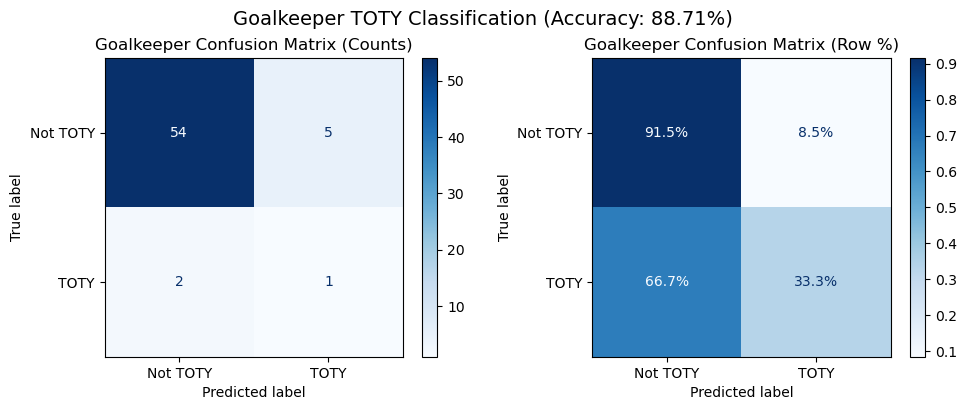

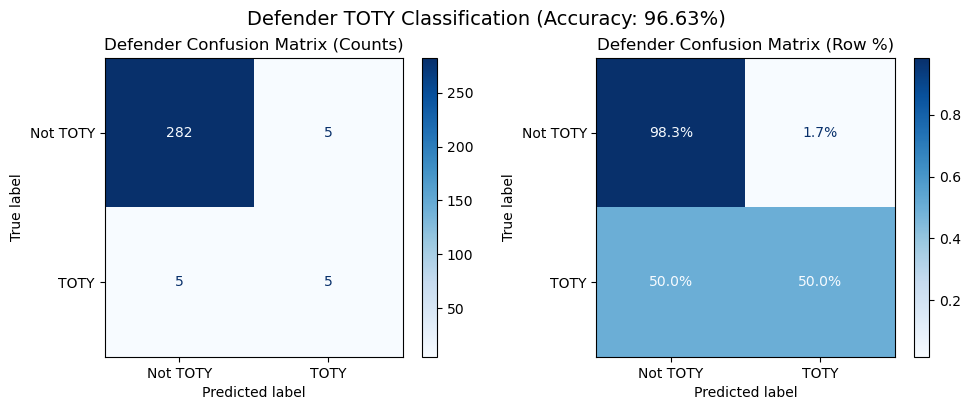

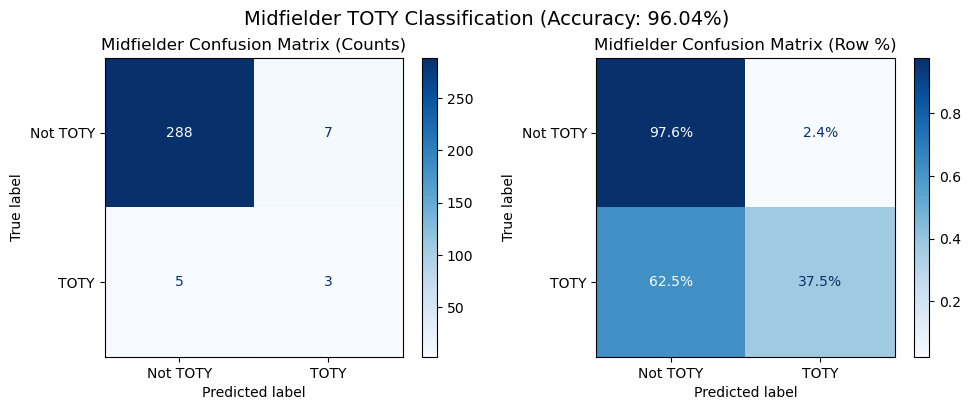

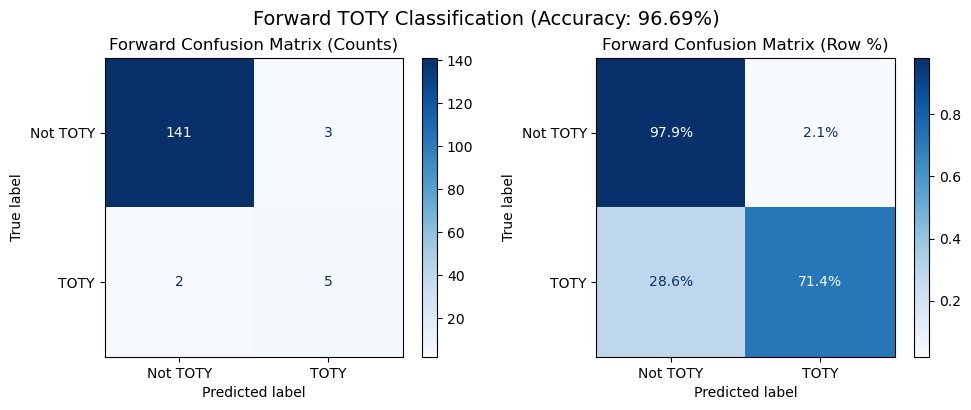

In [106]:
import matplotlib.pyplot as plt

for position, results in model_results.items():
        
        y_test = results['test_data'][1]
        y_pred = results['prediction']
        
        cm = confusion_matrix(y_test, y_pred)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not TOTY', 'TOTY'])
        disp.plot(ax=ax[0], cmap='Blues', values_format='d')
        ax[0].set_title(f'{position} Confusion Matrix (Counts)')
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['Not TOTY', 'TOTY'])
        disp.plot(ax=ax[1], cmap='Blues', values_format='.1%')
        ax[1].set_title(f'{position} Confusion Matrix (Row %)')
        
        # Add overall accuracy as text
        accuracy = np.trace(cm) / np.sum(cm)
        fig.suptitle(f'{position} TOTY Classification (Accuracy: {accuracy:.2%})', fontsize=14)
        
        plt.tight_layout()
        plt.show()

### Hyperparameter tuning

In [107]:
from sklearn.model_selection import GridSearchCV

param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }


for position, results in model_results.items():
    
    print(f"\nHyperparameter tuning for {position} model...")

    grid_search = GridSearchCV(
        estimator=results['classifier'],
        param_grid=param_grid,
        cv=5,
        scoring='roc_auc',
        verbose=1,
        n_jobs=-1,
    )
    
    position_df = model_df[model_df['position'] == position].copy()
    features_to_drop = feature_mask[position]
    X = position_df.drop(features_to_drop + ['position', 'toty_player'], axis=1)
    
    X_train_scaled = results['train_data'][0]
    y_train = results['train_data'][1]
    X_test_scaled = results['test_data'][0]
    y_test = results['test_data'][1]

    grid_search.fit(X_train_scaled, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best AUC score: {grid_search.best_score_:.4f}")


    best_classifier = XGBClassifier(
        **grid_search.best_params_,
        early_stopping_rounds=10,
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=results['pos_weight'],
        random_state=42
    )

    
    best_classifier.fit(
            X_train_scaled, y_train,
            eval_set=[(X_test_scaled, y_test)],
            verbose=False
        )

    y_pred = best_classifier.predict(X_test_scaled)
    y_pred_proba = best_classifier.predict_proba(X_test_scaled)[:, 1]


    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    
    importance_df = pd.DataFrame({
        'Features': X.columns,
        'Importance': best_classifier.feature_importances_
    }).sort_values('Importance', ascending=False)


    model_results[position] = {
            'classifier': best_classifier,
            'train_data': [X_train_scaled, y_train],
            'test_data': [X_test_scaled, y_test],
            'pos_weight': results['pos_weight'],
            'test_size': len(y_test),
            'toty_players_count': int(y_test.sum()),
            'prediction': y_pred,
            'pred_prob': y_pred_proba,
            'feature_names': X.columns, 
            'feature_importance': importance_df
        }

    print(f"\nResults for {position}:")
    print(f"Test set size: {model_results[position]['test_size']}")
    print(f"Number of TOTY players in test set: {model_results[position]['toty_players_count']}")
    print('\n-------------------------------------------------------')


Hyperparameter tuning for Goalkeeper model...
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
Best parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50, 'subsample': 0.8}
Best AUC score: 0.8818
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        59
           1       0.27      1.00      0.43         3

    accuracy                           0.87        62
   macro avg       0.64      0.93      0.68        62
weighted avg       0.96      0.87      0.90        62

AUC: 0.9746

Results for Goalkeeper:
Test set size: 62
Number of TOTY players in test set: 3

-------------------------------------------------------

Hyperparameter tuning for Defender model...
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_